# Amazon Fine Food Reviews Sentiment Analysis with Recurrent Neural Network

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import pandas as pd
import numpy as np
from collections import namedtuple
import tensorflow as tf
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc, classification_report

sns.set(color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Deep learning/Extracted dataset/Reviews.csv")

In [5]:
print("Number of reviews:",len(data))

Number of reviews: 568454


In [6]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Sentiment Score

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


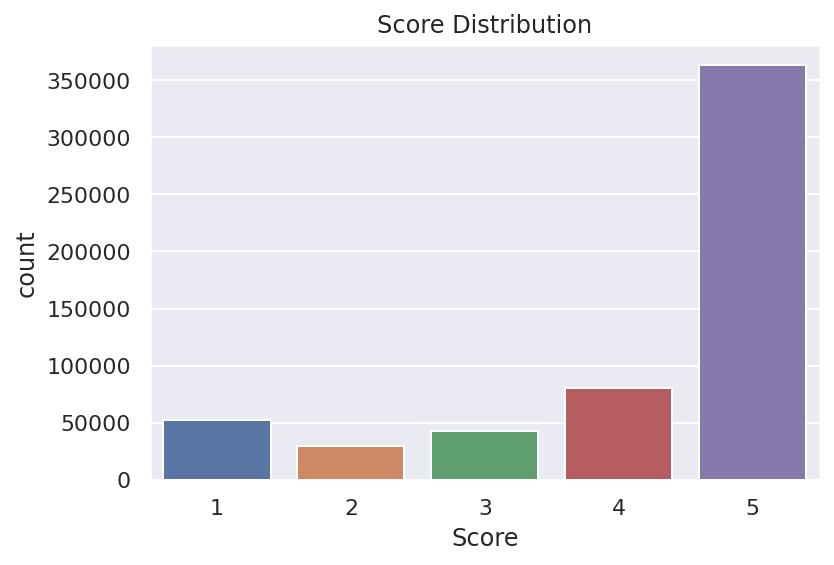

In [7]:
ax = plt.axes()
sns.countplot(data.Score,ax=ax)
ax.set_title('Score Distribution')
plt.show()

In [8]:
print("Average Score: ",np.mean(data.Score))
print("Median Score: ",np.median(data.Score))

Average Score:  4.183198640523243
Median Score:  5.0


In [9]:
data.loc[data.Score>3,'Sentiment']="POSITIVE"
data.loc[data.Score<=3,'Sentiment']="NEGATIVE"

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


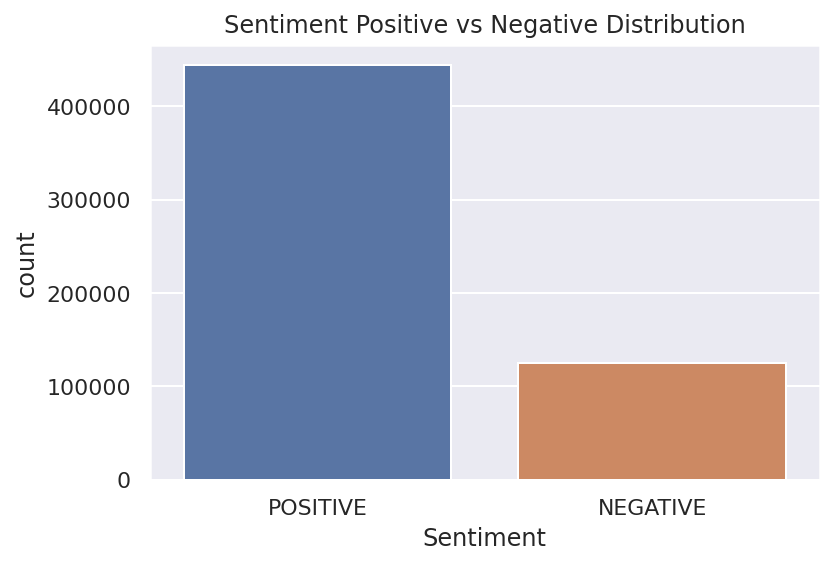

In [10]:
ax = plt.axes()
sns.countplot(data.Sentiment,ax=ax)
ax.set_title('Sentiment Positive vs Negative Distribution')
plt.show()

In [11]:
print("Proportion of positive review:", len(data[data.Sentiment=="POSITIVE"])/len(data))
print("Proportion of positive review:",len(data[data.Sentiment=="NEGATIVE"])/len(data))

Proportion of positive review: 0.7806735461444549
Proportion of positive review: 0.21932645385554503


In [12]:
reviews = data.Text.values
labels = data.Sentiment.values

### Text Reviews

In [13]:
def pretty_print_review_and_label(i):
    if data.Sentiment[i]=="POSITIVE":
        print("POSITIVE" + "\t" + reviews[i][:90] + "...")
    else:
        print("NEGATIVE" + "\t " + reviews[i][:90] + "...")

In [14]:
pretty_print_review_and_label(1)
pretty_print_review_and_label(4)
pretty_print_review_and_label(5)
pretty_print_review_and_label(50)

NEGATIVE	 Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized un...
POSITIVE	Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was v...
POSITIVE	I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoya...
NEGATIVE	 This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go....


In [15]:
positive_reviews = [reviews[i] for i in range(len(reviews)) if labels[i]=="POSITIVE"]
negative_reviews = [reviews[i] for i in range(len(reviews)) if labels[i]=="NEGATIVE"]

In [16]:
from collections import Counter

cnt_positve = Counter()

for row in positive_reviews:
    cnt_positve.update(row.split(" "))
print("Vocabulary size for positve reviews:", len(cnt_positve.keys()))

cnt_negative = Counter()

for row in negative_reviews:
    cnt_negative.update(row.split(" "))
print("Vocabulary size for positve reviews:", len(cnt_negative.keys()))

cnt_total = Counter()

for row in reviews:
    cnt_total.update(row.split(" "))
    

Vocabulary size for positve reviews: 480349
Vocabulary size for positve reviews: 239355


In [17]:
pos_neg_ratio = Counter()
vocab_pos_neg = (set(cnt_positve.keys())).intersection(set(cnt_negative.keys()))
for word in vocab_pos_neg:
    if cnt_total[word]>100:
        ratio = cnt_positve[word]/float(cnt_negative[word]+1)
        if ratio>1:
            pos_neg_ratio[word] = np.log(ratio)
        else:
            pos_neg_ratio[word] = -np.log(1/(ratio+0.01)) 

In [18]:
pos_neg_ratio .most_common()[:30]

[('/>Highly', 5.791488055075306),
 ('anytime.', 5.147494476813453),
 ('soothing.', 4.912654885736052),
 ('addictive!', 4.897839799950911),
 ('Enjoy.', 4.840242308167575),
 ('/>Magnesium', 4.721470641684252),
 ('/>Almonds', 4.709530201312334),
 ('versatile.', 4.6443908991413725),
 ('Rich,', 4.634728988229636),
 ('organs.', 4.532599493153256),
 ('hooked.', 4.516338972281476),
 ('Delicious!', 4.496630017412885),
 ('diet?', 4.448516375942715),
 ('/>1st', 4.442651256490317),
 ('Cakesters', 4.382026634673881),
 ('Booda', 4.377851263263401),
 ('far!', 4.3694478524670215),
 ('*****<br', 4.3652195163575005),
 ('Sciences', 4.33729074083249),
 ('Favorites"', 4.33729074083249),
 ('synthesis.', 4.33729074083249),
 ('Highly', 4.3313052590894525),
 ('Chili<br', 4.31748811353631),
 ('addicted!', 4.310799125385514),
 ('plus!', 4.30406509320417),
 ('favorites!', 4.30406509320417),
 ('Delicious.', 4.298645025734831),
 ('Yummy!', 4.295015257684252),
 ('disappoint!', 4.283586561860629),
 ('recommended!', 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


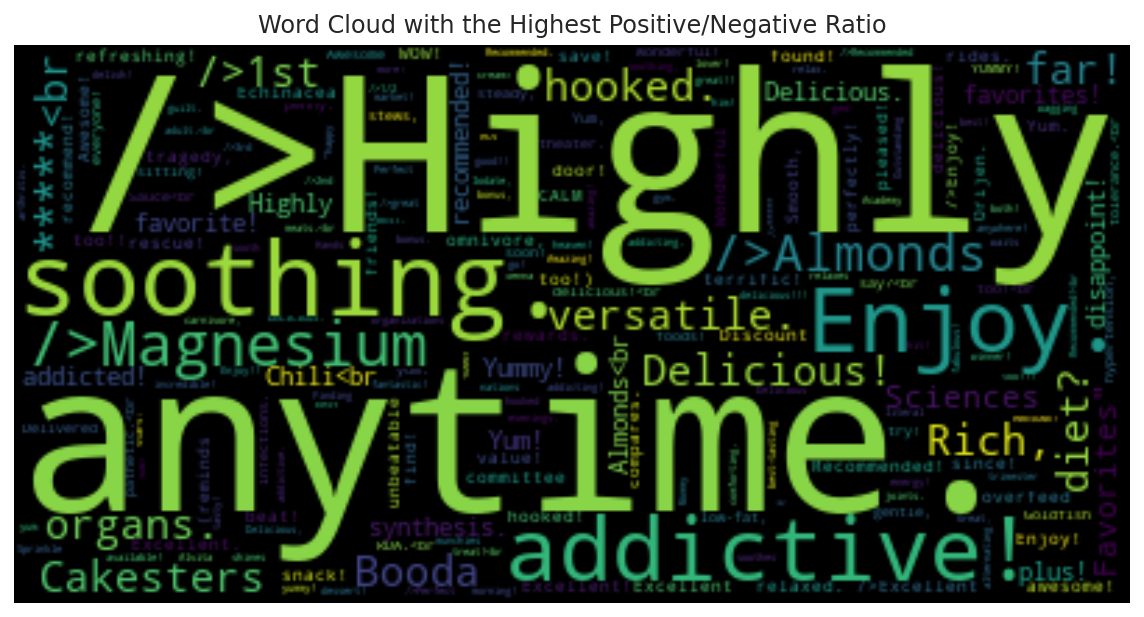

In [19]:
positive_dict = {}
for word, cnt in pos_neg_ratio.items():
    if (cnt>1):
        positive_dict[word] = cnt

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=positive_dict)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
ax = plt.axes()
ax.set_title('Word Cloud with the Highest Positive/Negative Ratio')
plt.show()

In [20]:
list(reversed(pos_neg_ratio.most_common()))[0:30]

[('FREAKS', -4.203010866014426),
 ('factory)', -4.201364829298291),
 ('judgment,', -4.201364829298291),
 ('mistakes.<br', -3.914513666740598),
 ('howling,', -3.912023005428146),
 ('NO<br', -3.328075116833193),
 ('sad.<br', -3.248146207168314),
 ('Reducing', -3.2188758248682006),
 ('Lives,', -3.2188758248682006),
 ('slaughterhouse', -3.1778728512505374),
 ('ANYMORE.', -3.1424854222041994),
 ('(good,', -3.1088233633266724),
 ('mischief.', -3.101092789211817),
 ('blue)', -2.9045009573244873),
 ('disappointment!', -2.8650573056222033),
 ('crying,', -2.7623992656292384),
 ('5/8', -2.745951587905034),
 ('"healthy,"', -2.7375866155346618),
 ('trashing', -2.6486357670125487),
 ('deliberately', -2.5174652359649476),
 ('returnable', -2.489919191611545),
 ('disorder.', -2.4825564724430467),
 ('Halo,', -2.4427317247372873),
 ('deceptive', -2.407945608651872),
 ('Horrible', -2.399007001651061),
 ('Buyer', -2.3765230838453015),
 ('twenty-five', -2.342112073137968),
 ('horrible!', -2.2335922215070942

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


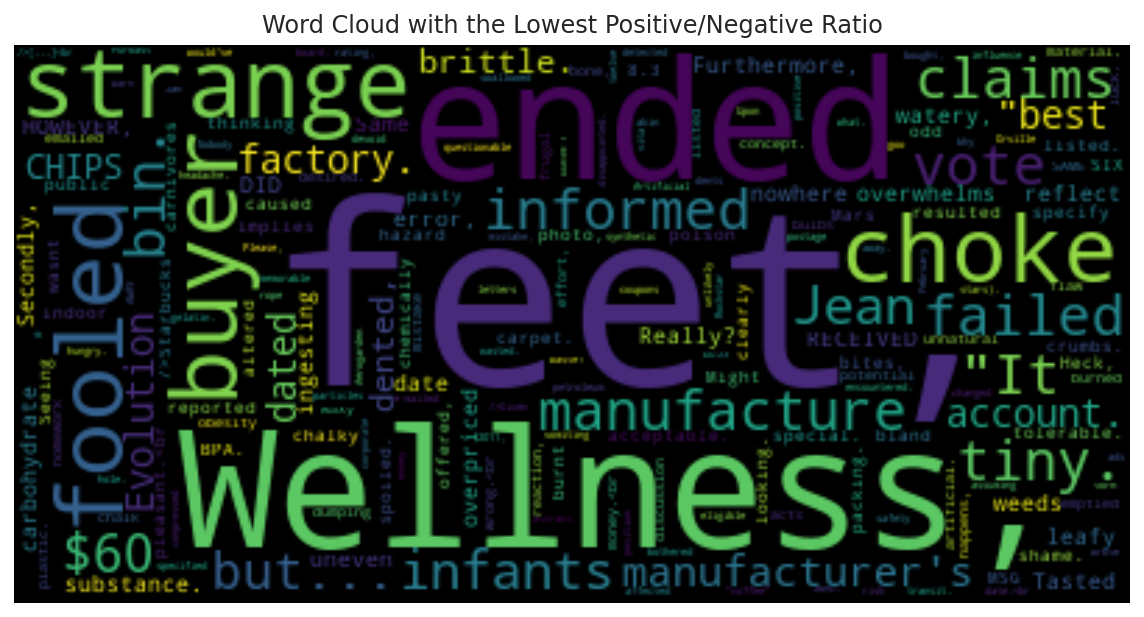

In [21]:
negative_dict = {}
for word, cnt in pos_neg_ratio.items():
    if (cnt<1) & (cnt>0):
        negative_dict[word] = -np.log(cnt)

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=negative_dict)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
ax = plt.axes()
ax.set_title('Word Cloud with the Lowest Positive/Negative Ratio')
plt.show()

## Data Preprocessing

In order to train our model, we had to transform the reviews into the right format. We performed the following steps:


In [22]:
reviews = data.Text.values
labels = np.array([1 if s=="POSITIVE" else 0 for s in data.Sentiment.values])

First we need to remove punctuations and transform all the characters into a list of integers.

In [23]:
reviews_cleaned = []
for i in range(len(reviews)):
    reviews_cleaned.append(''.join([c.lower() for c in reviews[i] if c not in punctuation]))

In [24]:
print("Before: ",reviews[0])
print("")
print("After: ",reviews_cleaned[0])

Before:  I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

After:  i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than  most


What's the size of the vocabulary after removing punctuations and transform characters to lower case?

In [25]:
vocabulary = set(' '.join(reviews_cleaned).split())
print("Vocabulary size: ", len(vocabulary))

Vocabulary size:  240772


## Noise reduction by reducing vocabulary

In [26]:
def vocabulary_reduction(reviews,min_freq=10,polarity_cut_off=0.1):
    
    pos_count = Counter()
    neg_count = Counter()
    tot_count = Counter()

    for i in range(len(reviews)):
        for word in reviews[i].split():
            tot_count[word]+=1
            if labels[i] == 1:
                pos_count[word]+=1
            else:
                neg_count[word]+=1    
    
    #Identify words with frequency greater than min_freq
    vocab_freq = []
    for word in tot_count.keys():
        if tot_count[word]>min_freq:
            vocab_freq.append(word)  
    
    #Use polarity to reduce vocab
    pos_neg_ratio = Counter()
    vocab_pos_neg = (set(pos_count.keys())).intersection(set(neg_count.keys()))
    for word in vocab_pos_neg:
        if tot_count[word]>100:
            ratio = pos_count[word]/float(neg_count[word]+1)
            if ratio>1:
                pos_neg_ratio[word] = np.log(ratio)
            else:
                pos_neg_ratio[word] = -np.log(1/(ratio+0.01)) 
    
    mean_ratio = np.mean(list(pos_neg_ratio.values()))
    
    vocab_polarity = []
    for word in pos_neg_ratio.keys():
        if (pos_neg_ratio[word]<(mean_ratio-polarity_cut_off)) or (pos_neg_ratio[word]>(mean_ratio+polarity_cut_off)):
            vocab_polarity.append(word)
     
    vocab_rm_polarity = set(pos_neg_ratio.keys()).difference(vocab_polarity)
    vocab_reduced = (set(vocab_freq)).difference(set(vocab_rm_polarity))
 
    reviews_cleaned = []
    
    for review in reviews:
        review_temp = [word for word in review.split() if word in vocab_reduced]
        reviews_cleaned.append(' '.join(review_temp))
    
    return reviews_cleaned

In [27]:
reviews_cleaned = vocabulary_reduction(reviews_cleaned,min_freq=0,polarity_cut_off=0)

In [28]:
# Store all the text from each review in a text variable
text = ' '.join(reviews_cleaned)

# List all the vocabulary contained in the reviews
vocabulary = set(text.split(' '))

# Map each word to an integer
vocabulary_to_int = {word:i for i,word in enumerate(vocabulary,0)}

In [29]:
def reviews_to_integers(reviews):
    reviews_to_int = []
    for i in range(len(reviews)):
        to_int = [vocabulary_to_int[word] for word in reviews[i].split()]
        reviews_to_int.append(to_int)
    return reviews_to_int

reviews_to_int = reviews_to_integers(reviews_cleaned)

In [30]:
review_lengths = [len(review) for review in reviews_to_int]
print("Shortest review:", min(review_lengths))
print("Longest revies:",max(review_lengths))

Shortest review: 3
Longest revies: 3414


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

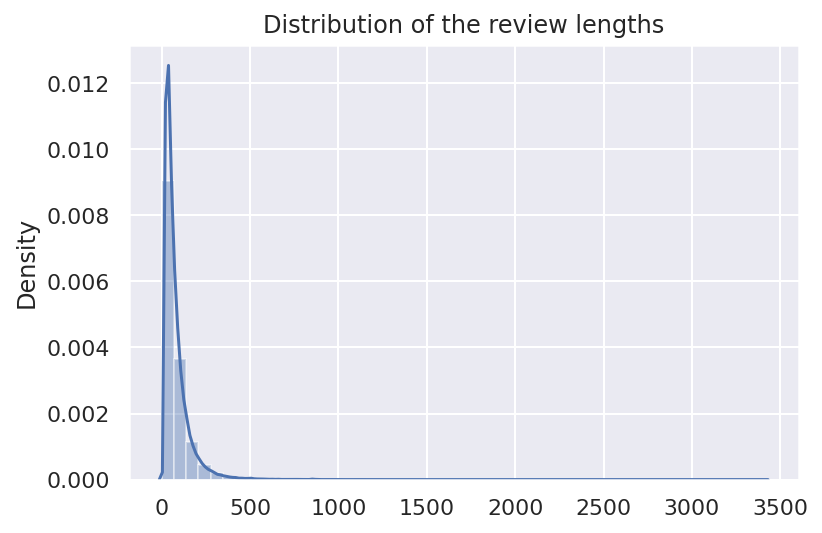

In [31]:
ax = plt.axes()
sns.distplot(review_lengths)
ax.set_title("Distribution of the review lengths")
plt.plot()

In [32]:
pd.DataFrame(review_lengths).describe()

,0
count,568454.000000
mean,79.913333
std,79.017418
min,3.000000
25%,33.000000
50%,56.000000
75%,97.000000
max,3414.000000


In [33]:
max_length = 200
features = np.zeros(shape=(len(reviews_to_int),max_length),dtype=int)

In [34]:
for i in range(len(reviews_to_int)):
    nb_words = len(reviews_to_int[i])
    features[i] = [0]*(max_length -nb_words) + reviews_to_int[i][:200]

### Training, validation and split

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit

In [36]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=5435)

splitter = sss.split(features, labels)
train_index, validation_index = next(splitter)
test_index = validation_index[:int(len(validation_index)/2)]
validation_index = validation_index[int(len(validation_index)/2):]

train_x, train_y = features[train_index], labels[train_index]
val_x, val_y = features[test_index], labels[test_index]
test_x, test_y = features[validation_index], labels[validation_index]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(454763, 200) 
Validation set: 	(56845, 200) 
Test set: 		(56846, 200)


In [37]:
lstm_size = 256
lstm_layers = 1
batch_size = 500
learning_rate = 0.001
embed_size = 200 

In [38]:
tf.compat.v1.disable_eager_execution()

In [39]:
def build_rnn(vocabulary_to_int,
              embed_size=embed_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              lstm_size=lstm_size,
              lstm_layers=lstm_layers):
    
    tf.compat.v1.reset_default_graph()
    
    n_words = len(vocabulary_to_int)
    
    with tf.name_scope('inputs'):
        inputs_ = tf.compat.v1.placeholder(tf.int32,[None, None],name='inputs_')
    with tf.name_scope('labels'):
        labels_ = tf.compat.v1.placeholder(tf.int32,[None, None],name='labels_')
    with tf.name_scope('keep_prob'):    
        keep_prob = tf.compat.v1.placeholder(tf.float32,name='keep_prob')
      
         
    with tf.name_scope('embedding'):
        embedding = tf.Variable(tf.compat.v1.random_normal((n_words,embed_size),-1,1),name='embedding_')
        embed = tf.nn.embedding_lookup(embedding,inputs_)
        
    with tf.name_scope("RNN_cells"):
        lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

        # Add dropout to the cell
        drop = tf.contrib.rnn.DropoutWrapper(lstm,output_keep_prob=keep_prob)

        # Stack up multiple LSTM layers, for deep learning
        cell = tf.contrib.rnn.MultiRNNCell([drop]*lstm_layers)
        
        with tf.name_scope("RNN_init_state"):
            # Getting an initial state of all zeros
            initial_state = cell.zero_state(batch_size, tf.float32)
    
    with tf.name_scope("RNN_forward"):
        outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)
        
    with tf.name_scope('predictions'):
        predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, 
                                                        activation_fn=tf.sigmoid,
                                                        weights_initializer=
                                                        tf.truncated_normal_initializer(stddev=0.1))   
    with tf.name_scope('cost'):
        cost = tf.losses.mean_squared_error(labels_, predictions)
        tf.summary.scalar('cost', cost)
    
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.name_scope('accuracy'):
        correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    merged = tf.summary.merge_all()
    
    # Export the nodes 
    export_nodes = ['inputs_', 'labels_','initial_state', 'final_state',
                    'keep_prob', 'cell', 'cost', 'predictions', 'optimizer',
                    'accuracy','merged']
    
    Graph = namedtuple('Graph', export_nodes)
    
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

In [40]:
graph = build_rnn(vocabulary_to_int,
              embed_size=embed_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              lstm_size=lstm_size,
              lstm_layers=lstm_layers)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('output/logs/1', sess.graph)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions 

In [41]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [42]:
epochs = 5

def train(model, epoch,train_writer,test_writer):
    
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        iteration = 1
        for e in range(epochs):
            state = sess.run(model.initial_state)

            for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
                feed = {model.inputs_: x,
                        model.labels_: y[:, None],
                        model.keep_prob: 0.5,
                        model.initial_state: state}
                summary,loss, state, _ = sess.run([model.merged,model.cost, 
                                                   model.final_state, 
                                                   model.optimizer], feed_dict=feed)

                if iteration%5==0:
                    print("Epoch: {}/{}".format(e, epochs),
                          "Iteration: {}".format(iteration),
                          "Train loss: {:.3f}".format(loss))

                train_writer.add_summary(summary, iteration)

                if iteration%25==0:
                    val_acc = []
                    val_state = sess.run(model.cell.zero_state(batch_size, tf.float32))
                    for x, y in get_batches(val_x, val_y, batch_size):
                        feed = {model.inputs_: x,
                                model.labels_: y[:, None],
                                model.keep_prob: 1,
                                model.initial_state: val_state}
                        summary, batch_acc, val_state = sess.run([model.merged,model.accuracy, 
                                                         model.final_state], feed_dict=feed)
                        val_acc.append(batch_acc)

                    test_writer.add_summary(summary,iteration)
                    print("Val acc: {:.3f}".format(np.mean(val_acc)))

                iteration +=1
        saver.save(sess, "output/checkpoints/sentiment.ckpt")

In [43]:
lstm_size_options = [256]
lstm_layers_options = [1]
learning_rate_options = [0.001]

#lstm_size_options = [128,256,512]
#lstm_layers_options = [1, 2]
#learning_rate_options = [0.002, 0.001]

In [44]:
for lstm_size in lstm_size_options:
    for lstm_layers in lstm_layers_options:
        for learning_rate in learning_rate_options:
            log_string_train = 'output/logs/2/train/lr={},rl={},ru={}'.format(learning_rate, lstm_layers, lstm_size)
            log_string_test = 'output/logs/2/test/lr={},rl={},ru={}'.format(learning_rate, lstm_layers, lstm_size)
            train_writer = tf.summary.FileWriter(log_string_train)
            test_writer = tf.summary.FileWriter(log_string_test)
            
            print("lstm size: {}".format(lstm_size),
                    "nb layers : {}".format(lstm_layers),
                    "learn rate : {:.3f}".format(learning_rate))
            
            model = build_rnn(vocabulary_to_int,
                      embed_size=embed_size,
                      batch_size=batch_size,
                      learning_rate=learning_rate,
                      lstm_size=lstm_size,
                      lstm_layers=lstm_layers)

            train(model, epochs, train_writer,test_writer)

lstm size: 256 nb layers : 1 learn rate : 0.001
Epoch: 0/5 Iteration: 5 Train loss: 0.201
Epoch: 0/5 Iteration: 10 Train loss: 0.237
Epoch: 0/5 Iteration: 15 Train loss: 0.256
Epoch: 0/5 Iteration: 20 Train loss: 0.201
Epoch: 0/5 Iteration: 25 Train loss: 0.189
Val acc: 0.780
Epoch: 0/5 Iteration: 30 Train loss: 0.167
Epoch: 0/5 Iteration: 35 Train loss: 0.182
Epoch: 0/5 Iteration: 40 Train loss: 0.182
Epoch: 0/5 Iteration: 45 Train loss: 0.172
Epoch: 0/5 Iteration: 50 Train loss: 0.173
Val acc: 0.780
Epoch: 0/5 Iteration: 55 Train loss: 0.192
Epoch: 0/5 Iteration: 60 Train loss: 0.178
Epoch: 0/5 Iteration: 65 Train loss: 0.183
Epoch: 0/5 Iteration: 70 Train loss: 0.165
Epoch: 0/5 Iteration: 75 Train loss: 0.174
Val acc: 0.780
Epoch: 0/5 Iteration: 80 Train loss: 0.178
Epoch: 0/5 Iteration: 85 Train loss: 0.182
Epoch: 0/5 Iteration: 90 Train loss: 0.183
Epoch: 0/5 Iteration: 95 Train loss: 0.178
Epoch: 0/5 Iteration: 100 Train loss: 0.161
Val acc: 0.780
Epoch: 0/5 Iteration: 105 Train 

In [45]:
tf.train.get_checkpoint_state('output/checkpoints')

model_checkpoint_path: "output/checkpoints/sentiment.ckpt"
all_model_checkpoint_paths: "output/checkpoints/sentiment.ckpt"

## Model Evaluation and Validation

In [46]:
test_acc = []
test_pred = []
test_label = []
    
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "output/checkpoints/sentiment.ckpt")
    test_state = sess.run(model.cell.zero_state(batch_size, tf.float32))
    
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {model.inputs_: x,
                model.labels_: y[:, None],
                model.keep_prob: 1,
                model.initial_state: test_state}
        batch_pred, batch_acc, test_state = sess.run([model.predictions,model.accuracy, model.final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        test_pred = np.append(test_pred,batch_pred)
        test_label = np.append(test_label,y)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from output/checkpoints/sentiment.ckpt
Test accuracy: 0.931


In [47]:
fpr, tpr, _ = roc_curve(test_label, test_pred)
roc_auc = auc(fpr, tpr)

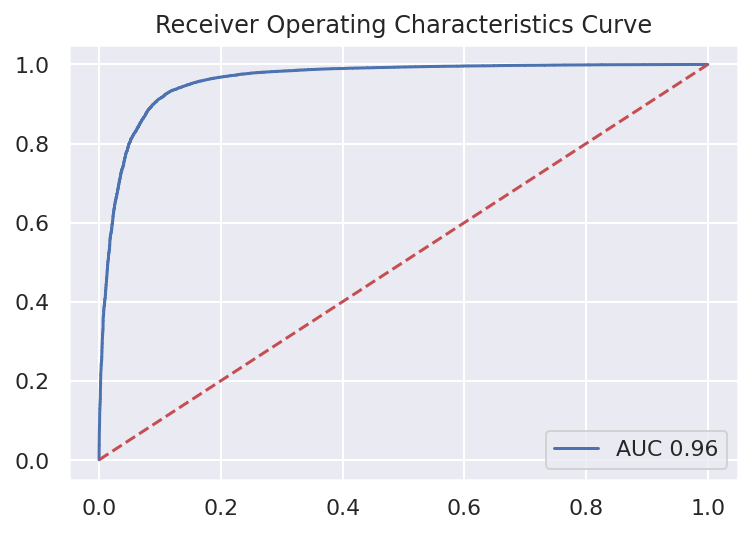

In [48]:
plt.plot(fpr, tpr, label='AUC %0.2f'%(roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.title("Receiver Operating Characteristics Curve")
plt.show()

In [49]:
print(classification_report(test_label, list(map(lambda x: round(x), test_pred))))

              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84     12363
         1.0       0.95      0.96      0.96     44137

    accuracy                           0.93     56500
   macro avg       0.90      0.89      0.90     56500
weighted avg       0.93      0.93      0.93     56500

